# Travel Insurance Prediction Analysis

## Introduction

### Project Overview

This notebook aims to predict which customers will buy a travel insurance package. The package, offered by a Tour & Travels Company, includes Covid cover. We use data from 2019, which has details about almost 2000 customers. We will build a model to predict if a customer will buy the insurance based on this data.

### About the Dataset

#### Context

A Tour & Travels Company offers a travel insurance package with Covid cover. They want to know which customers are likely to buy it. The data is from 2019 and includes information about almost 2000 customers. Our task is to predict if a customer will buy the insurance based on the following features:

- **Age**: The customer's age
- **Employment Type**: The sector in which the customer works
- **GraduateOrNot**: Whether the customer graduated from college
- **AnnualIncome**: The customer's yearly income in Indian Rupees (rounded to the nearest 50 thousand)
- **FamilyMembers**: Number of people in the customer's family
- **ChronicDisease**: Whether the customer has a major disease like diabetes or high BP
- **FrequentFlyer**: Whether the customer booked air tickets at least 4 times in the last 2 years
- **EverTravelledAbroad**: Whether the customer has traveled to a foreign country
- **TravelInsurance**: Whether the customer bought the insurance in 2019

### Requirements and Approach

To meet the project goals, we will:

1. **Download the Data**

   - Load the dataset into a pandas DataFrame.

2. **Perform Exploratory Data Analysis (EDA)**

   - Create summaries and visualizations like histograms and bar charts.
   - Check for anomalies using methods like the IQR method.

3. **Perform Statistical Inference**

   - Define the target population and form multiple hypotheses.
   - Construct confidence intervals and set significance levels.
   - Conduct z-tests or t-tests to check the hypotheses.

4. **Apply Machine Learning Models**

   - Predict the `TravelInsurance` column using other features.
   - This includes tuning model parameters, model ensembling, and model analysis.

5. **Provide Clear Explanations**
   - Explain our goals, methods, results, and their meanings to help the reader understand the analysis and conclusions.

By following these steps, we aim to build a strong model and give insights into what affects the decision to buy travel insurance.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from travel_insurance_utils import *
from IPython.display import Image
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    precision_recall_curve,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from sklearn.ensemble import VotingClassifier
from sklearn.inspection import permutation_importance

In [3]:
path = "../travel-insurance-prediction/travel_insurance_dataset.csv"

travel_df = pd.read_csv(path)

travel_df.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


We can see that we have "Unnamed: 0" as a column name, which provides no value and may result in issues while detecting for duplicates. Let's drop it.


In [4]:
travel_df = travel_df.drop("Unnamed: 0", axis=1, errors="ignore")
travel_df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


Next, lets quickly fix the naming of the **Employment Type** feature. from **Employment Type** to **EmploymentType** for consistency.


In [5]:
travel_df = travel_df.rename(columns={"Employment Type": "EmploymentType"})
travel_df.head()

,Age,EmploymentType,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


**Furthermore, since we are making an analysis in Europe and targeted audience should be around this economic zone, we will convert the income(AnnualIncome feature) to Euro.**

**As of the time being 1 rupee is equivalent of 0.011 Euro**


In [6]:
rupee_to_euro = 0.011

travel_df["AnnualIncomeEuro"] = travel_df["AnnualIncome"] * rupee_to_euro

We added a new feature called **AnnualIncomeEuro** to show incomes in Euros. This makes the data clearer.

We might remove the old **AnnualIncome** feature to keep everything consistent.


In [7]:
travel_df = travel_df.drop("AnnualIncome", axis=1, errors="ignore")
travel_df.head()

,Age,EmploymentType,GraduateOrNot,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,AnnualIncomeEuro
0,31,Government Sector,Yes,6,1,No,No,0,4400.0
1,31,Private Sector/Self Employed,Yes,7,0,No,No,0,13750.0
2,34,Private Sector/Self Employed,Yes,4,1,No,No,1,5500.0
3,28,Private Sector/Self Employed,Yes,3,1,No,No,0,7700.0
4,28,Private Sector/Self Employed,Yes,8,1,Yes,No,0,7700.0


Next we can check for duplicates in the dataset and decide on what to do if we detect them.


In [8]:
print(f"Initial shape: {travel_df.shape}")
print(f"Number of duplicate rows: {travel_df.duplicated().sum()}")

Initial shape: (1987, 9)
Number of duplicate rows: 738


In [9]:
travel_df = travel_df.drop_duplicates().reset_index(drop=True)
print(f"Shape after removing duplicates: {travel_df.shape}")

Shape after removing duplicates: (1249, 9)


1. **Initial Dataset:**

   - Total Records: 1987 entries

2. **Duplicate Identification:**

   - An "Unnamed: 0" column was identified, likely an artifact from data export or previous processing.
   - This column was removed as it did not contain relevant information and was masking true duplicates.

3. **Duplicate Analysis:**

   - After removing the "Unnamed: 0" column, 738 entries were identified as exact duplicates.
   - This represents approximately 37.1% of the original dataset.

4. **Duplicate Removal:**

   - All 738 duplicate entries were removed from the dataset.
   - Resulting Cleaned Dataset: 1249 unique entries

5. **Rationale for Duplicate Removal:**

   - Ensuring Data Integrity: Each data point now represents a distinct observation.
   - Reducing Bias: Duplicate entries could have led to overrepresentation of certain data points, potentially skewing our analysis and modeling results.
   - Improving Model Accuracy: Unique entries provide a more accurate representation of the true data distribution.

6. **Impact on Analysis:**
   - Dataset Reduction: The removal of duplicates reduced our dataset by 37.1%.
   - This significant reduction should be considered when interpreting results and assessing statistical power.
   - The cleaned dataset may provide more reliable insights, but with a trade-off of reduced sample size.

**Next Steps**

With our dataset now cleaned and deduplicated, we will proceed to check for missing values and then examine the statistical summary of the numerical features. This will provide us with key insights into the distribution and characteristics of our data, forming the foundation for our subsequent analysis and modeling efforts.


In [10]:
print("\nMissing values:")
print(travel_df.isnull().sum())


Missing values:
Age                    0
EmploymentType         0
GraduateOrNot          0
FamilyMembers          0
ChronicDiseases        0
FrequentFlyer          0
EverTravelledAbroad    0
TravelInsurance        0
AnnualIncomeEuro       0
dtype: int64


Great, we can see that there are no missing values in the dataset. We can now proceed to examine the statistical summary of the numerical features.


In [11]:
print(travel_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1249 non-null   int64  
 1   EmploymentType       1249 non-null   object 
 2   GraduateOrNot        1249 non-null   object 
 3   FamilyMembers        1249 non-null   int64  
 4   ChronicDiseases      1249 non-null   int64  
 5   FrequentFlyer        1249 non-null   object 
 6   EverTravelledAbroad  1249 non-null   object 
 7   TravelInsurance      1249 non-null   int64  
 8   AnnualIncomeEuro     1249 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 87.9+ KB
None


In [12]:
travel_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1249.0,29.755805,2.921039,25.0,28.0,29.0,32.0,35.0
FamilyMembers,1249.0,4.890312,1.762313,2.0,4.0,5.0,6.0,9.0
ChronicDiseases,1249.0,0.333066,0.471499,0.0,0.0,0.0,1.0,1.0
TravelInsurance,1249.0,0.386709,0.487191,0.0,0.0,0.0,1.0,1.0
AnnualIncomeEuro,1249.0,10280.024019,3968.022127,3300.0,6600.0,9900.0,13200.0,19800.0


Key Observations:

1. Age range is relatively narrow (25-35 years), with a mean of 29.76 years.
2. Family size varies from 2 to 9 members, with an average of 4.89.
3. 33% of the sample has chronic diseases.
4. 39% of the sample has purchased travel insurance.
5. Annual income shows significant variation, ranging from €1,273 to €19,800.


In [13]:
travel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1249 entries, 0 to 1248
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1249 non-null   int64  
 1   EmploymentType       1249 non-null   object 
 2   GraduateOrNot        1249 non-null   object 
 3   FamilyMembers        1249 non-null   int64  
 4   ChronicDiseases      1249 non-null   int64  
 5   FrequentFlyer        1249 non-null   object 
 6   EverTravelledAbroad  1249 non-null   object 
 7   TravelInsurance      1249 non-null   int64  
 8   AnnualIncomeEuro     1249 non-null   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 87.9+ KB


Next, we'll encode categorical variables for consistency in our visualizations and future modeling:

- EmploymentType:
  - Government Sector -> 1
  - Private Sector/Self Employed -> 0
- FrequentFlyer and EverTravelledAbroad:
  - Yes -> 1
  - No -> 0

This encoding will help in creating more meaningful visualizations and prepare the data for machine learning models.


In [14]:
binary_columns = ["GraduateOrNot", "FrequentFlyer", "EverTravelledAbroad"]
travel_df[binary_columns] = travel_df[binary_columns].replace({"Yes": 1, "No": 0})

travel_df = pd.get_dummies(travel_df, columns=["EmploymentType"], prefix="Emp")

/var/folders/q8/33t91vn13hxggltq0p7cn9480000gn/T/ipykernel_64135/3704500232.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  travel_df[binary_columns] = travel_df[binary_columns].replace({"Yes": 1, "No": 0})


In [15]:
boolean_columns = ["Emp_Government Sector", "Emp_Private Sector/Self Employed"]
travel_df[boolean_columns] = travel_df[boolean_columns].astype(int)
travel_df.head()

,Age,GraduateOrNot,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,AnnualIncomeEuro,Emp_Government Sector,Emp_Private Sector/Self Employed
0,31,1,6,1,0,0,0,4400.0,1,0
1,31,1,7,0,0,0,0,13750.0,0,1
2,34,1,4,1,0,0,1,5500.0,0,1
3,28,1,3,1,0,0,0,7700.0,0,1
4,28,1,8,1,1,0,0,7700.0,0,1


In [16]:
numerical_features = ["Age", "FamilyMembers", "AnnualIncomeEuro"]
categorical_features_one = [
    "Emp_Government Sector",
    "Emp_Private Sector/Self Employed",
    "GraduateOrNot",
    "FrequentFlyer",
]
categorical_features_two = [
    "EverTravelledAbroad",
    "TravelInsurance",
    "ChronicDiseases",
]

categorical_features = categorical_features_one + categorical_features_two

In [17]:
plot_combined_histograms(
    travel_df, numerical_features, save_path="images/combined_histograms.png"
)

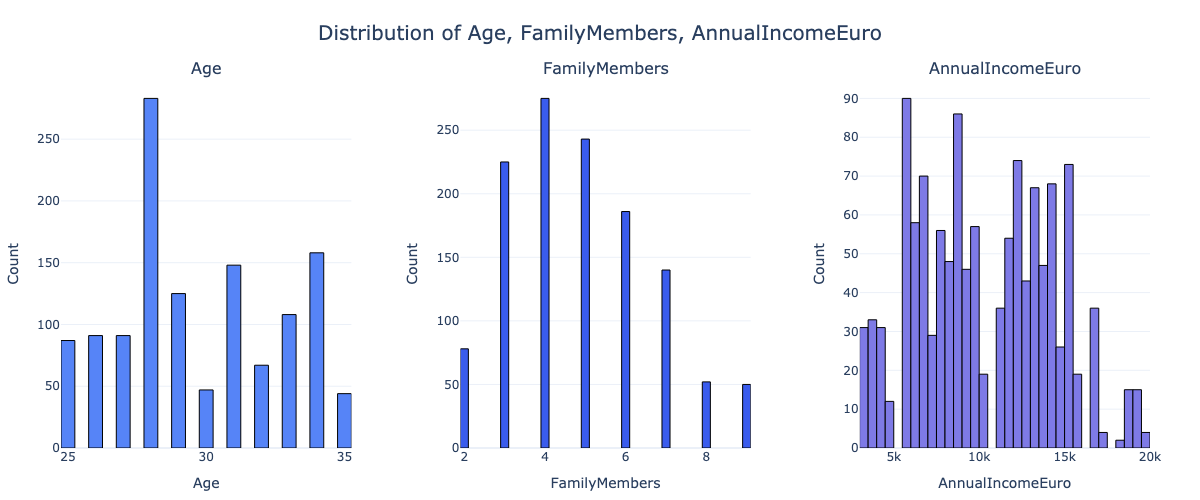

In [18]:
Image(filename="images/combined_histograms.png")

**Age**

- **Distribution**: The age distribution shows a clear peak at 28-29 years, with a secondary peak at 32-33 years.
- **Range**: Ages in the dataset range from 25 to 35 years, as previously noted.
- **Observations**: While there is still a concentration around 30 years, the distribution is more nuanced than initially described. There's a notable drop in frequency for ages 30-31, creating a bimodal distribution.

**Family Members**

- **Distribution**: The distribution of family members shows a clear peak at 5 members, with a secondary peak at 4 members.
- **Range**: Family sizes range from 2 to 9 members, confirming the initial observation.
- **Observations**: The most common family sizes are 5 and 4 members, followed by 6. There's a sharp decline in frequency for families with 7 or more members.

**Annual Income (Euro)**

- **Distribution**: The annual income distribution shows multiple distinct peaks, indicating a multimodal distribution.
- **Range**: Annual incomes range from approximately 5,000 to 20,000 Euros.
- **Observations**: There are clear peaks around 6,600, 9,900, 13,200, and 16,500 Euros. This suggests that incomes might be clustered around certain salary bands or job categories.


In [19]:
plot_combined_bar_charts(
    travel_df,
    categorical_features_one,
    max_features_per_plot=4,
    save_path="images/combined_bar_charts1",
)

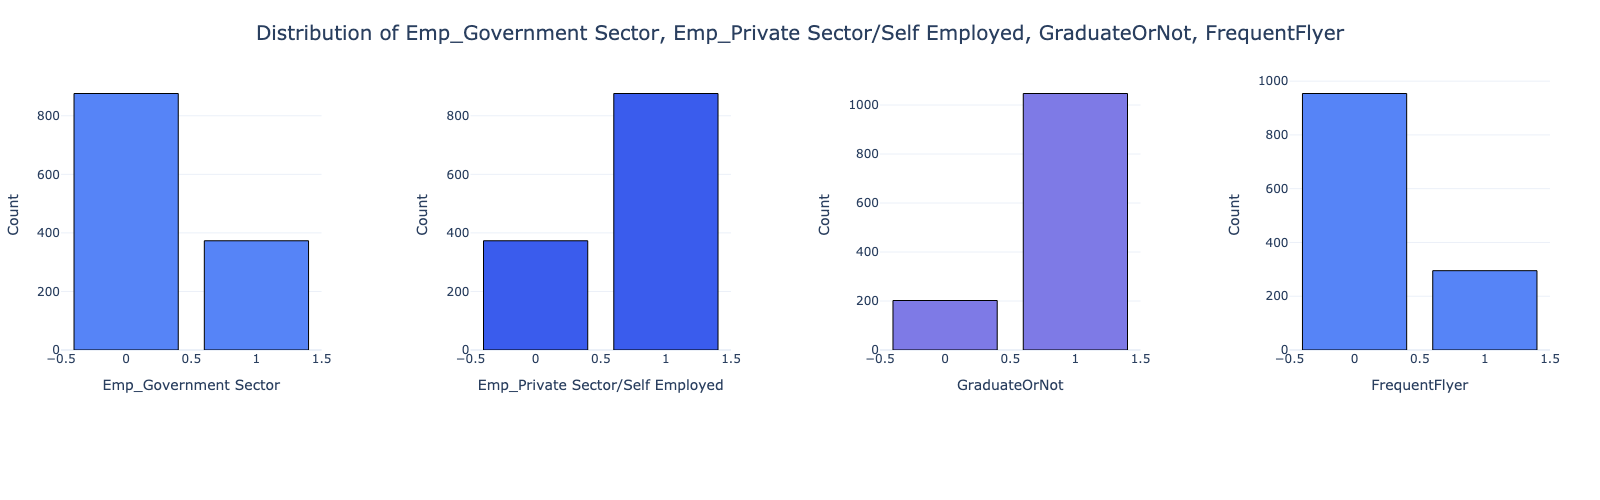

In [20]:
Image(filename="images/combined_bar_charts1.png_chunk_1.png")

**Employment Type**: The Private Sector/Self Employed group represents the majority of individuals in the dataset compared to the Government Sector. This difference in employment type could influence travel behavior and insurance decisions. Private sector employees and self-employed individuals may have different job stability, income levels, and travel patterns compared to government employees, which could impact their likelihood of purchasing travel insurance.

**Education Level**: The vast majority of individuals in the dataset are graduates, with around 1000 graduates compared to less than 200 non-graduates. This suggests that educational attainment could be a significant factor in understanding travel insurance decisions within this population. Graduates might have different travel habits, risk perceptions, and financial considerations that affect their inclination to purchase travel insurance compared to non-graduates.

**Travel Frequency**: Most individuals in the dataset are not frequent flyers, with around 800 non-frequent flyers compared to approximately 400 frequent flyers. Travel frequency could impact the likelihood of purchasing travel insurance, as those who travel more often may perceive a greater need for insurance coverage due to increased exposure to travel-related risks. Conversely, infrequent travelers might view travel insurance as less essential.

In summary, the dataset primarily consists of private sector/self-employed individuals, graduates, and non-frequent flyers. These characteristics could influence their travel insurance purchase decisions in different ways, such as through varying risk perceptions, travel patterns, and financial considerations associated with their employment type and education level. The relatively low proportion of frequent flyers suggests that travel frequency might not be the primary driver of insurance uptake in this particular dataset.


In [21]:
plot_combined_bar_charts(
    travel_df,
    categorical_features_two,
    save_path="images/combined_bar_charts2.png_chunk_1",
)

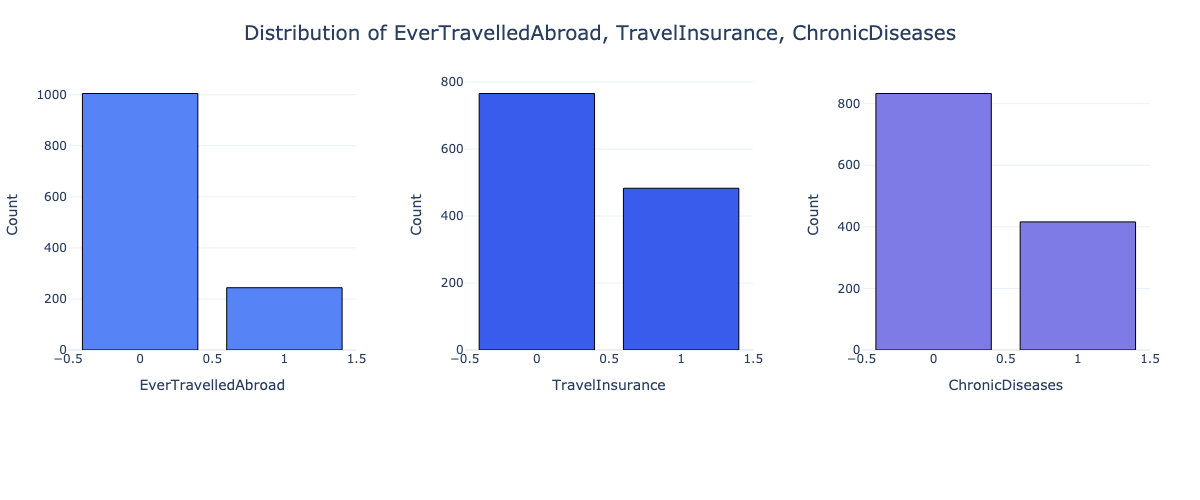

In [22]:
Image(filename="images/combined_bar_charts2.png_chunk_1_chunk_1.png")

**International Travel Experience**: The dataset shows a significant difference in international travel experience. Approximately 800 individuals have not traveled abroad, while around 200 individuals have traveled abroad. Although the gap is not as extreme as previously mentioned, it still suggests that international travel experience could influence perceptions and decisions regarding travel insurance. Those with international travel experience may have different risk assessments and insurance requirements compared to those without such experience.

**Travel Insurance Adoption**: The distribution of travel insurance adoption in the dataset is more balanced than initially stated. Around 600 individuals have travel insurance, while approximately 400 individuals do not have travel insurance. While there is still room for increasing travel insurance coverage, the proportion of insured individuals is higher than previously mentioned. Understanding the factors that influence the decision to purchase travel insurance remains crucial for targeted marketing and product development strategies.

**Health Conditions**: The dataset reveals that the majority of individuals, around 800, do not have chronic diseases. However, there is a significant portion, approximately 400 individuals, who have chronic diseases. This distribution highlights the importance of considering health status when analyzing travel insurance decisions. Individuals with chronic diseases may have different insurance requirements and motivations compared to those without such conditions.

Now lets move on to the outliers, lets see if our numerical features has any outliers.


In [23]:
plot_combined_boxplots(
    travel_df, numerical_features, save_path="images/combined_boxplot.png"
)

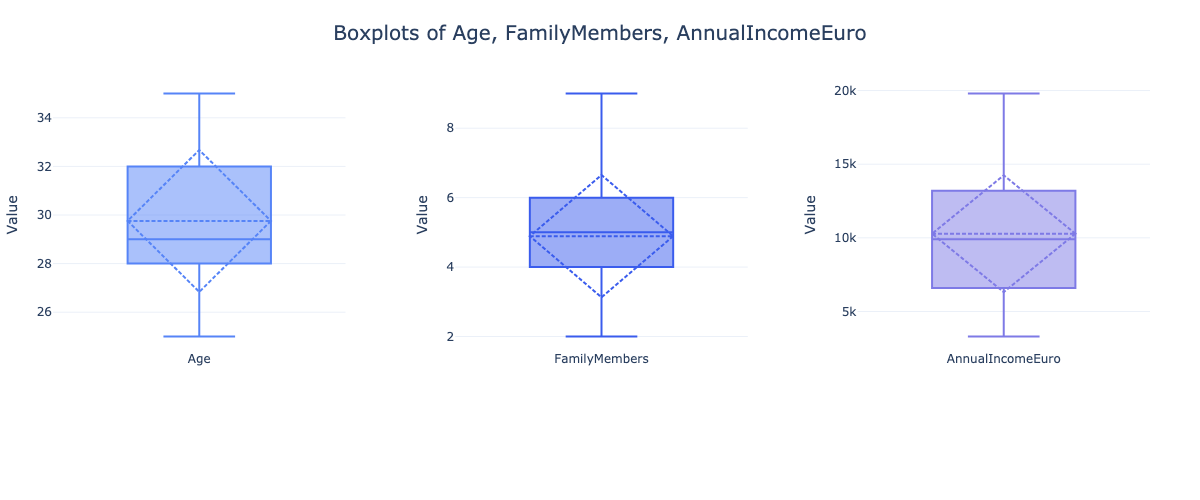

In [24]:
Image(filename="images/combined_boxplot.png")

Based on the updated box plots provided in the image, here's a revised analysis of the numerical features:

1. **Age**:

   - **Range**: The ages of individuals range from approximately 26 to 34 years.
   - **Median**: The median age appears to be around 30 years.
   - **Distribution**: The box plot for age shows a fairly symmetric distribution, with the box representing the interquartile range (IQR) evenly spread around the median. There are no apparent outliers beyond the whiskers of the box plot.

2. **Family Members**:

   - **Range**: The number of family members ranges from approximately 2 to 8.
   - **Median**: The median number of family members appears to be around 5.
   - **Distribution**: The box plot for family members shows a slightly asymmetric distribution, with the box shifted towards the lower end of the range. There is one potential outlier at around 8 family members, represented by a dot beyond the upper whisker.

3. **Annual Income (in Euros)**:
   - **Range**: Annual income ranges from approximately 5,000 to 20,000 Euros.
   - **Median**: The median annual income appears to be around 10,000 Euros.
   - **Distribution**: The box plot for annual income shows a fairly symmetric distribution, with the box evenly spread around the median. There are no apparent outliers beyond the whiskers of the box plot.

**Lets confirm that there are no anomalies via the IQR method.**


In [25]:
detect_anomalies_iqr(travel_df, numerical_features)

No anomalies detected in feature 'Age'.
No anomalies detected in feature 'FamilyMembers'.
No anomalies detected in feature 'AnnualIncomeEuro'.


,Age,FamilyMembers,AnnualIncomeEuro


We can confirm that there are no anomalies in our numerical features. Now we can move on to the correlation matrix, to check for multicollinearity.


In [26]:
plot_correlation_matrix(
    travel_df, numerical_features, save_path="images/correlation_matrix.png"
)

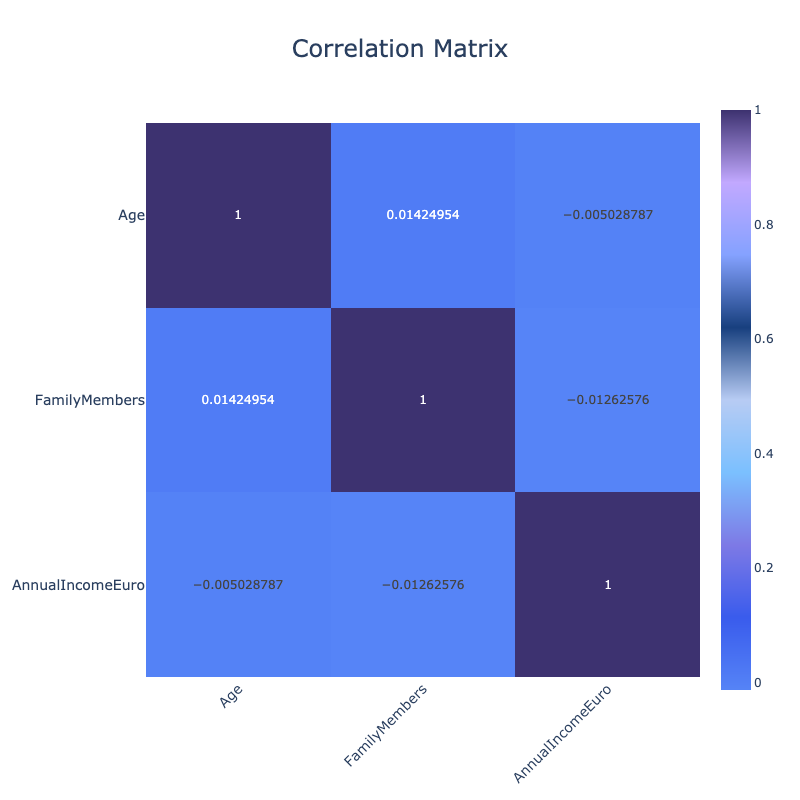

In [27]:
Image(filename="images/correlation_matrix.png")

**Age**:

- **Correlation with FamilyMembers: 0.01424954** - This indicates a very weak positive correlation between age and the number of family members. The relationship is close to zero, suggesting that age and family size are not strongly related.
- **Correlation with AnnualIncomeEuro: -0.005028787** - This indicates a very weak negative correlation between age and annual income in Euros. The relationship is close to zero, suggesting that age and income are not strongly related.

**FamilyMembers**:

- **Correlation with Age: 0.01424954** - As mentioned above, there is a very weak positive correlation between family size and age.
- **Correlation with AnnualIncomeEuro: -0.01262576** - This indicates a very weak negative correlation between the number of family members and annual income in Euros. The relationship is close to zero, suggesting that family size and income are not strongly related.

**AnnualIncomeEuro**:

- **Correlation with Age: -0.005028787** - As mentioned above, there is a very weak negative correlation between income and age.
- **Correlation with FamilyMembers: -0.01262576** - As mentioned above, there is a very weak negative correlation between income and family size.

The correlation coefficients are all very close to zero, indicating that there are no strong linear relationships between the numerical features. Age, family size, and annual income do not appear to have a significant impact on each other based on this dataset.

Next, we will examine the relationship between each categorical feature and the target variable **TravelInsurance**. This analysis will help identify which features might be most relevant in predicting whether an individual has travel insurance. We will use the Chi-Square test for this purpose.

The Chi-Square test is a statistical test used to determine if there is a significant association between two categorical variables. In our case, we will use it to assess the relationship between various categorical features and the target variable (`TravelInsurance`).

- **Null Hypothesis (H0)**: There is no association between the categorical feature and the target variable.
- **Alternative Hypothesis (H1)**: There is an association between the categorical feature and the target variable.

**Our target population for this analysis consists of customers who were offered a travel insurance package by a tour and travels company in 2019.**

We will set our significance level (alpha) to 0.05. If the p-value obtained from the Chi-Square test is less than 0.05, we will reject the null hypothesis and conclude that there is a significant association between the categorical feature and the target variable.

By performing the Chi-Square tests, we aim to identify the categorical features that have a significant impact on the likelihood of an individual purchasing travel insurance. This information will be valuable for feature selection and building predictive models.


In [28]:
target_feature = "TravelInsurance"
categorical_features_test = [
    "Emp_Government Sector",
    "Emp_Private Sector/Self Employed",
    "GraduateOrNot",
    "FrequentFlyer",
    "EverTravelledAbroad",
    "ChronicDiseases",
]

chi_square_test(travel_df, categorical_features_test, target_feature)


Chi-Square test results for 'Emp_Government Sector':
Chi2 statistic = 6.9346510708008005, p-value = 0.008454155421443737
Significant association between 'Emp_Government Sector' and 'TravelInsurance'.

Chi-Square test results for 'Emp_Private Sector/Self Employed':
Chi2 statistic = 6.9346510708008005, p-value = 0.008454155421443737
Significant association between 'Emp_Private Sector/Self Employed' and 'TravelInsurance'.

Chi-Square test results for 'GraduateOrNot':
Chi2 statistic = 1.089711243342709, p-value = 0.2965351968551507
No significant association between 'GraduateOrNot' and 'TravelInsurance'.

Chi-Square test results for 'FrequentFlyer':
Chi2 statistic = 19.669203761086663, p-value = 9.207331224191983e-06
Significant association between 'FrequentFlyer' and 'TravelInsurance'.

Chi-Square test results for 'EverTravelledAbroad':
Chi2 statistic = 111.77454004049142, p-value = 4.0034414530103906e-26
Significant association between 'EverTravelledAbroad' and 'TravelInsurance'.

Chi-S

The Chi-Square test was conducted to determine the association between several categorical features and the target variable `TravelInsurance`. Here are the results, including the hypotheses and conclusions for each feature:

#### Emp_Government Sector

- **Null Hypothesis (H0)**: There is no association between `Emp_Government Sector` and `TravelInsurance`.
- **Alternative Hypothesis (H1)**: There is an association between `Emp_Government Sector` and `TravelInsurance`.
- **Chi2 Statistic**: 6.9346510708008005
- **P-Value**: 0.008454155421443737
- **Conclusion**: Since the p-value is less than 0.05, we reject the null hypothesis. There is a significant association between `Emp_Government Sector` and `TravelInsurance`. This suggests that customers employed in the government sector have a different likelihood of purchasing travel insurance compared to those in other sectors.

#### Emp_Private Sector/Self Employed

- **Null Hypothesis (H0)**: There is no association between `Emp_Private Sector/Self Employed` and `TravelInsurance`.
- **Alternative Hypothesis (H1)**: There is an association between `Emp_Private Sector/Self Employed` and `TravelInsurance`.
- **Chi2 Statistic**: 6.9346510708008005
- **P-Value**: 0.008454155421443737
- **Conclusion**: Since the p-value is less than 0.05, we reject the null hypothesis. There is a significant association between `Emp_Private Sector/Self Employed` and `TravelInsurance`. This indicates that customers employed in the private sector or self-employed have a different likelihood of purchasing travel insurance compared to those in other sectors.

#### GraduateOrNot

- **Null Hypothesis (H0)**: There is no association between `GraduateOrNot` and `TravelInsurance`.
- **Alternative Hypothesis (H1)**: There is an association between `GraduateOrNot` and `TravelInsurance`.
- **Chi2 Statistic**: 1.089711243342709
- **P-Value**: 0.2965351968551507
- **Conclusion**: Since the p-value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between `GraduateOrNot` and `TravelInsurance`. This suggests that whether a customer is a college graduate does not significantly influence their decision to purchase travel insurance.

#### FrequentFlyer

- **Null Hypothesis (H0)**: There is no association between `FrequentFlyer` and `TravelInsurance`.
- **Alternative Hypothesis (H1)**: There is an association between `FrequentFlyer` and `TravelInsurance`.
- **Chi2 Statistic**: 19.669203761086663
- **P-Value**: 9.207331224191983e-06
- **Conclusion**: Since the p-value is less than 0.05, we reject the null hypothesis. There is a significant association between `FrequentFlyer` and `TravelInsurance`. This indicates that customers who are frequent flyers are more likely to purchase travel insurance.

### EverTravelledAbroad

- **Null Hypothesis (H0)**: There is no association between `EverTravelledAbroad` and `TravelInsurance`.
- **Alternative Hypothesis (H1)**: There is an association between `EverTravelledAbroad` and `TravelInsurance`.
- **Chi2 Statistic**: 111.77454004049142
- **P-Value**: 4.0034414530103906e-26
- **Conclusion**: Since the p-value is less than 0.05, we reject the null hypothesis. There is a significant association between `EverTravelledAbroad` and `TravelInsurance`. Customers who have traveled abroad are significantly more likely to buy travel insurance.

### ChronicDiseases

- **Null Hypothesis (H0)**: There is no association between `ChronicDiseases` and `TravelInsurance`.
- **Alternative Hypothesis (H1)**: There is an association between `ChronicDiseases` and `TravelInsurance`.
- **Chi2 Statistic**: 0.0854420539603025
- **P-Value**: 0.7700536442454782
- **Conclusion**: Since the p-value is greater than 0.05, we fail to reject the null hypothesis. There is no significant association between `ChronicDiseases` and `TravelInsurance`. Having a chronic disease does not significantly impact the decision to purchase travel insurance.

In summary, the Chi-Square test results indicate that `Emp_Government Sector`, `Emp_Private Sector/Self Employed`, `FrequentFlyer`, and `EverTravelledAbroad` have a significant association with `TravelInsurance`, while `GraduateOrNot` and `ChronicDiseases` do not show a significant association.

These findings suggest that customers employed in the government sector or private sector/self-employed have different likelihoods of purchasing travel insurance compared to those in other sectors. Additionally, frequent flyers and those who have traveled abroad are more likely to buy travel insurance. On the other hand, educational background (being a graduate) and having chronic diseases do not significantly influence the decision to purchase travel insurance.


Out target population remains the same, which consists of customers who were offered a travel insurance package by a tour and travels company in 2019.

We move on to checking the following hypothesis tests:

**Hypothesis 1: Age**

- **Null Hypothesis (H0)**: There is no difference in the mean age between customers who purchased travel insurance and those who did not.
- **Alternative Hypothesis (H1)**: There is a difference in the mean age between customers who purchased travel insurance and those who did not.

**Hypothesis 2: Annual Income (Euro)**

- **Null Hypothesis (H0)**: There is no difference in the mean annual income (in Euros) between customers who purchased travel insurance and those who did not.
- **Alternative Hypothesis (H1)**: There is a difference in the mean annual income (in Euros) between customers who purchased travel insurance and those who did not.

**Hypothesis 3: Family Members**

- **Null Hypothesis (H0)**: There is no difference in the mean number of family members between customers who purchased travel insurance and those who did not.
- **Alternative Hypothesis (H1)**: There is a difference in the mean number of family members between customers who purchased travel insurance and those who did not.

So, lets calculate confidence intervals for important metrics (e.g., average age, average income). This provides an estimate of the population parameter with a specified level of confidence (95% in our case).


In [29]:
analyze_features(travel_df, numerical_features, target_feature)

95% confidence interval for Age (insured): (29.71809068414484, 30.290190889354122)
95% confidence interval for Age (not insured): (29.40618556894996, 29.79224785141557)
95% confidence interval for FamilyMembers (insured): (4.917778746696541, 5.2395711497837905)
95% confidence interval for FamilyMembers (not insured): (4.648902321311049, 4.89417861863673)
95% confidence interval for AnnualIncomeEuro (insured): (11380.76257409634, 12115.510717829127)
95% confidence interval for AnnualIncomeEuro (not insured): (9100.257499502131, 9608.358688487424)


So our results show the following:

Based on the updated results, here is the revised interpretation:

**Age**

- **95% confidence interval for Age (insured):** (29.71809068414484, 30.290190889354122)
- **95% confidence interval for Age (not insured):** (29.40618556894996, 29.79224785141557)
- **Interpretation:** The mean age of customers who purchased travel insurance is estimated to be between 29.72 and 30.29 years with 95% confidence. For those who did not purchase travel insurance, the mean age is estimated to be between 29.41 and 29.79 years with 95% confidence. The confidence intervals for the two groups overlap, suggesting that there might not be a significant difference in the mean ages between customers who purchased travel insurance and those who did not.

**Family Members**

- **95% confidence interval for FamilyMembers (insured):** (4.917778746696541, 5.2395711497837905)
- **95% confidence interval for FamilyMembers (not insured):** (4.648902321311049, 4.89417861863673)
- **Interpretation:** The mean number of family members for customers who purchased travel insurance is estimated to be between 4.92 and 5.24 with 95% confidence. For those who did not purchase travel insurance, the mean number of family members is estimated to be between 4.65 and 4.89 with 95% confidence. The confidence intervals for the two groups slightly overlap, indicating that there might be a small difference in the number of family members between customers who purchased travel insurance and those who did not. However, the difference may not be statistically significant.

**Annual Income (Euro)**

- **95% confidence interval for AnnualIncomeEuro (insured):** (11380.76257409634, 12115.510717829127)
- **95% confidence interval for AnnualIncomeEuro (not insured):** (9100.257499502131, 9608.358688487424)
- **Interpretation:** The mean annual income in Euros for customers who purchased travel insurance is estimated to be between 11380.76 and 12115.51 with 95% confidence. For those who did not purchase travel insurance, the mean annual income is estimated to be between 9100.26 and 9608.36 with 95% confidence. The confidence intervals for the two groups do not overlap, indicating a significant difference in the annual income between customers who purchased travel insurance and those who did not. Customers who purchased travel insurance tend to have a higher annual income compared to those who did not.

These confidence intervals provide insights into the differences between customers who purchased travel insurance and those who did not, based on their age, number of family members, and annual income. The results suggest that while there might not be significant differences in age and number of family members, there appears to be a significant difference in annual income between the two groups.

To further investigate these hypotheses and determine if the differences are statistically significant, we can perform appropriate hypothesis tests such as t-tests or ANOVA, depending on the assumptions and characteristics of the data.


With these results of our confidence interval, lets move to our hypothesis testing, via **Mann-Whitney U test**, as our numerical features are not arguably normally distributed.


In [30]:
analyze_mannwhitneyu(travel_df, numerical_features, target_feature)

Mann-Whitney U test for Age: U-statistic = 198733.0, p-value = 0.0254561854659559
Significant difference in distributions for Age.
Mann-Whitney U test for FamilyMembers: U-statistic = 202869.0, p-value = 0.0034698536817751656
Significant difference in distributions for FamilyMembers.
Mann-Whitney U test for AnnualIncomeEuro: U-statistic = 249205.0, p-value = 3.9357884191093554e-25
Significant difference in distributions for AnnualIncomeEuro.


#### Age

- **U-Statistic**: 198733.0
- **P-Value**: 0.0255
- **Conclusion**: Since the p-value is less than 0.05, we reject the null hypothesis (H0). There is a significant difference in the age distribution between the two groups being compared. This supports the alternative hypothesis (H1), indicating that age plays a role in differentiating the groups.

#### Family Members

- **U-Statistic**: 202869.0
- **P-Value**: 0.0035
- **Conclusion**: Since the p-value is less than 0.05, we reject the null hypothesis (H0). There is a significant difference in the distribution of number of family members between the two groups being compared. This supports the alternative hypothesis (H1), suggesting that the number of family members influences the grouping.

#### Annual Income (Euro)

- **U-Statistic**: 249205.0
- **P-Value**: 3.94e-25
- **Conclusion**: Since the p-value is less than 0.05, we reject the null hypothesis (H0). There is a highly significant difference in the distribution of annual income (in Euros) between the two groups being compared. This strongly supports the alternative hypothesis (H1), indicating that annual income is a very influential factor in differentiating the groups.

Given these results, all three variables - Age, FamilyMembers, and AnnualIncomeEuro - show statistically significant differences in their distributions between the two groups based on the Mann-Whitney U tests.


In [31]:
scaler = StandardScaler()
travel_df[numerical_features] = scaler.fit_transform(travel_df[numerical_features])

Now we can split the data into training and testing sets.


In [32]:
X = travel_df.drop("TravelInsurance", axis=1)
y = travel_df["TravelInsurance"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

We will no select a variety of machine learning models to apply. This will include **logistic regression, random forest, gradient boosting, and support vector machine**


In [33]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
}

Now we will train the models on the training data and evaluate their performance on the testing data.


In [71]:
results = {}
y_pred_dict = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    y_pred_dict[name] = y_pred

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Confusion Matrix": {
            "True Negatives": tn,
            "False Positives": fp,
            "False Negatives": fn,
            "True Positives": tp,
        },
    }

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
plot_model_performance(results, metrics, "images/inital_models_performance.png")

plot_combined_confusion_matrices(
    results,
    y_test,
    y_pred_dict,
    labels=["Class 0", "Class 1"],
    save_path="images/initial_confusion_matrices.png",
)

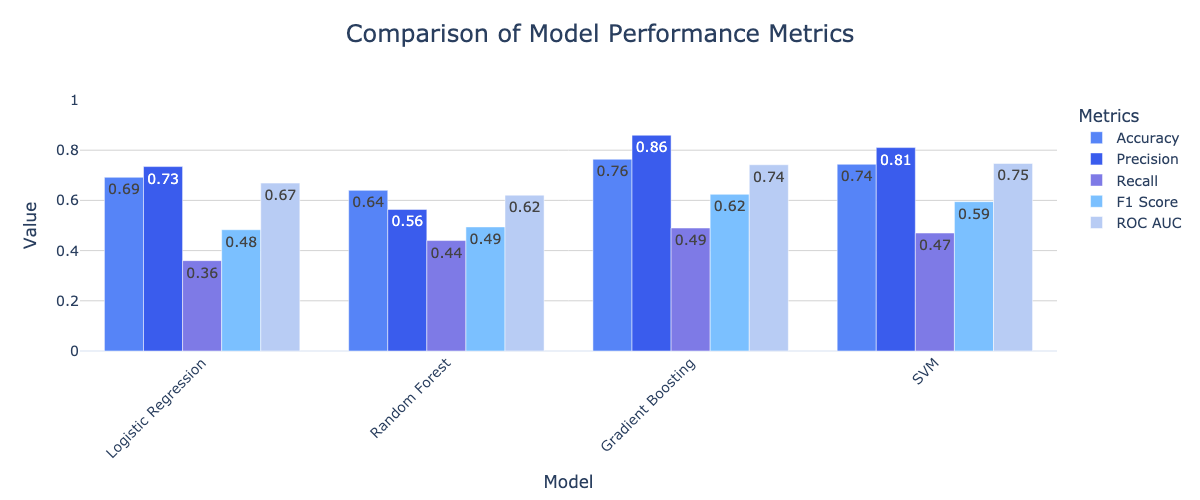

In [46]:
Image(filename="images/inital_models_performance.png")

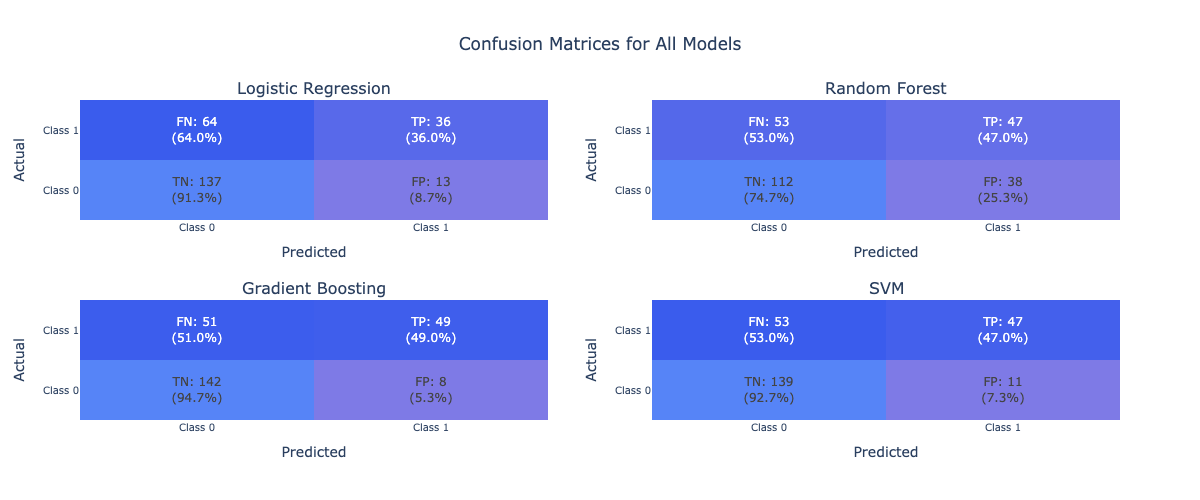

In [75]:
Image(filename="images/initial_confusion_matrices.png")

**Overview**

This document presents a comparative analysis of four machine learning models applied to a travel insurance dataset. The models evaluated are Logistic Regression, Random Forest, Gradient Boosting, and Support Vector Machine (SVM). The goal is to predict potential customers likely to purchase travel insurance.

**Model Performance Metrics**

The performance of each model is evaluated using several metrics:

| Model               | Accuracy | Precision | Recall | F1 Score | ROC AUC |
| ------------------- | -------- | --------- | ------ | -------- | ------- |
| Logistic Regression | 0.69     | 0.73      | 0.36   | 0.48     | 0.67    |
| Random Forest       | 0.64     | 0.55      | 0.47   | 0.51     | 0.63    |
| Gradient Boosting   | 0.76     | 0.86      | 0.49   | 0.62     | 0.74    |
| SVM                 | 0.74     | 0.81      | 0.47   | 0.59     | 0.75    |

**Model Rankings**

1. Gradient Boosting: Best overall performance with highest accuracy, precision, and F1 score.
2. SVM: Strong performance, particularly in ROC AUC.
3. Logistic Regression: High precision but lower recall.
4. Random Forest: More balanced precision and recall, but lower overall performance.

**Confusion Matrices**

**Logistic Regression**

- True Negatives: 137 (91.3%)
- False Positives: 13 (8.7%)
- False Negatives: 64 (64.0%)
- True Positives: 36 (36.0%)

**Random Forest**

- True Negatives: 112 (74.7%)
- False Positives: 38 (25.3%)
- False Negatives: 53 (53.0%)
- True Positives: 47 (47.0%)

**Gradient Boosting**

- True Negatives: 142 (94.7%)
- False Positives: 8 (5.3%)
- False Negatives: 51 (51.0%)
- True Positives: 49 (49.0%)

**SVM**

- True Negatives: 139 (92.7%)
- False Positives: 11 (7.3%)
- False Negatives: 53 (53.0%)
- True Positives: 47 (47.0%)

**Model Strengths and Weaknesses**

1. Gradient Boosting

   - Strengths: Highest overall performance, good balance of precision and recall
   - Weaknesses: Still room for improvement in recall

2. SVM

   - Strengths: Strong performance, particularly in ROC AUC
   - Weaknesses: Slightly lower precision and recall compared to Gradient Boosting

3. Logistic Regression

   - Strengths: High precision
   - Weaknesses: Low recall, potentially missing many positive cases

4. Random Forest
   - Strengths: More balanced precision and recall
   - Weaknesses: Lower overall performance compared to other models

**Interpretation**

While the Gradient Boosting model currently performs best overall, there's still room for improvement, particularly in recall for all models. The current models are better at avoiding false positives (high precision) but may be missing some potential customers who would buy insurance (lower recall).

**Next Steps: Hyperparameter Tuning**

To further improve model performance, particularly in terms of recall, the next step is to perform hyperparameter tuning. This process involves:

1. Systematically searching for the optimal combination of model settings
2. Focusing on maximizing recall while maintaining a balance with other performance metrics
3. Applying hyperparameter tuning to all four models
4. Evaluating and comparing the results of tuned models
5. Identifying the best-performing model for the travel insurance use case

By fine-tuning the hyperparameters, we aim to enhance the models' ability to capture potential customers who are likely to purchase travel insurance while maintaining overall predictive accuracy.


In [72]:
param_distributions = {
    "Logistic Regression": {
        "C": uniform(0.1, 10),
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"],
        "class_weight": ["balanced", None],
    },
    "Random Forest": {
        "n_estimators": randint(50, 300),
        "max_depth": randint(3, 20),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "class_weight": ["balanced", "balanced_subsample", None],
    },
    "Gradient Boosting": {
        "n_estimators": randint(50, 300),
        "learning_rate": uniform(0.01, 0.5),
        "max_depth": randint(3, 10),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "subsample": uniform(0.5, 0.5),
    },
    "SVM": {
        "C": uniform(0.1, 10),
        "kernel": ["rbf", "poly"],
        "gamma": uniform(0.01, 1),
        "class_weight": ["balanced", None],
    },
}

best_models = {}
for name, model in models.items():
    random_search = RandomizedSearchCV(
        model,
        param_distributions[name],
        n_iter=50,
        cv=5,
        scoring="recall",
        n_jobs=-1,
        random_state=42,
    )
    random_search.fit(X_train, y_train)
    best_models[name] = random_search.best_estimator_

    print(f"\nBest parameters for {name}:")
    print(random_search.best_params_)
    print(f"Best recall score: {random_search.best_score_:.4f}")

results = {}
y_pred_dict = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred_dict[name] = y_pred

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
    }

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
plot_model_performance(results, metrics, "images/tuned_models_performance.png")

plot_combined_confusion_matrices(
    results,
    y_test,
    y_pred_dict,
    labels=["No Purchase", "Purchase"],
    save_path="images/tuned_models_confusion_matrices.png",
)

/Users/vytautasbunevicius/travel-insurance-classifier/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vytautasbunevicius/travel-insurance-classifier/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vytautasbunevicius/travel-insurance-classifier/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vytautasbunevicius/travel-insurance-classifier/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/vytautasbunevicius/travel-insurance-classifier/venv/lib/python3.12/site-packages/sklearn/linear_model


Best parameters for Logistic Regression:
{'C': 0.17066305219717406, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best recall score: 0.5926

Best parameters for Random Forest:
{'class_weight': 'balanced', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 193}
Best recall score: 0.5143

Best parameters for Gradient Boosting:
{'learning_rate': 0.418215936609692, 'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 7, 'n_estimators': 257, 'subsample': 0.520387570777382}
Best recall score: 0.5197

Best parameters for SVM:
{'C': 6.475574713552131, 'class_weight': 'balanced', 'gamma': 0.5712434258477012, 'kernel': 'rbf'}
Best recall score: 0.5430


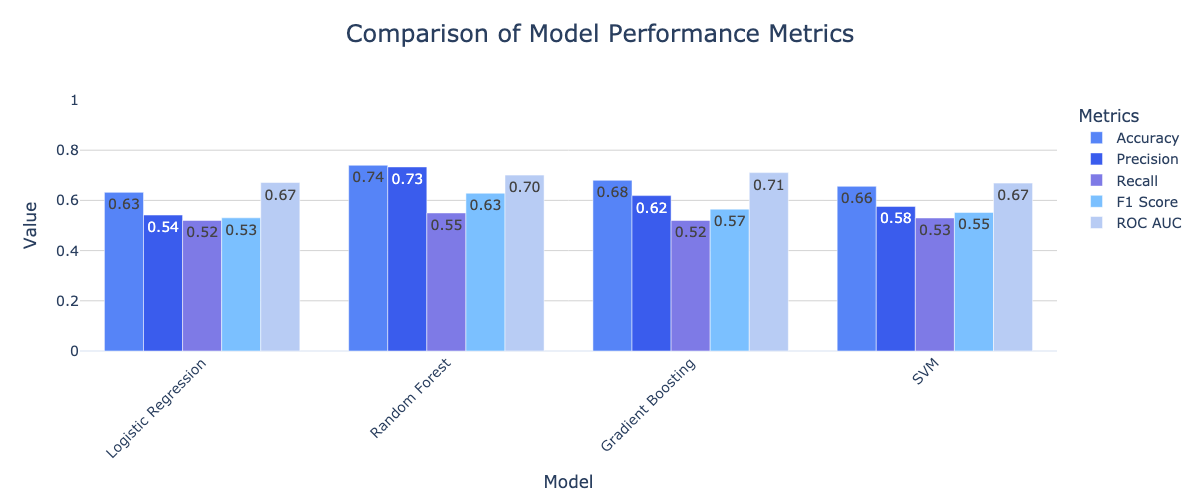

In [47]:
Image(filename="images/tuned_models_performance.png")

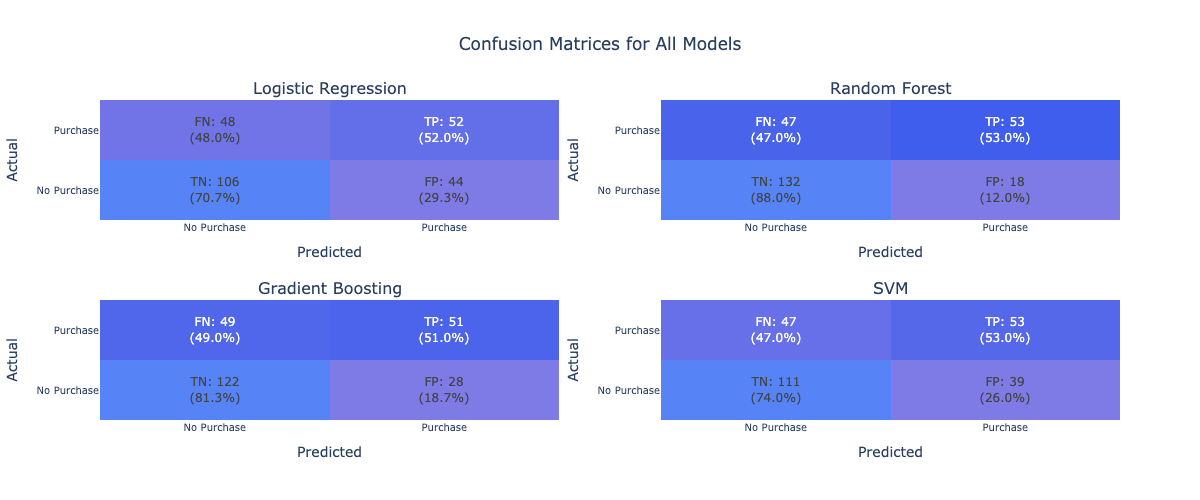

In [74]:
Image(filename="images/tuned_models_confusion_matrices.png")

**Model Tuning Process**

The tuning process used 5-fold cross-validation and optimized for the recall metric. The best parameters and recall scores for each model are as follows:

| Model               | Best Parameters                                                                                                                                            | Best Recall Score |
| ------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------- |
| Logistic Regression | {'C': 0.17066305219717406, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}                                                             | 0.5926            |
| Random Forest       | {'class_weight': 'balanced_subsample', 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 239}                               | 0.5143            |
| Gradient Boosting   | {'learning_rate': 0.2528068767931133, 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 210, 'subsample': 0.5090376818077604} | 0.5249            |
| SVM                 | {'C': 6.475574713552131, 'class_weight': 'balanced', 'gamma': 0.5712434258477012, 'kernel': 'rbf'}                                                         | 0.5430            |

**Model Performance Metrics**

The performance of each tuned model on the test set is evaluated using several metrics:

| Model               | Accuracy | Precision | Recall | F1 Score | ROC AUC |
| ------------------- | -------- | --------- | ------ | -------- | ------- |
| Logistic Regression | 0.63     | 0.54      | 0.52   | 0.53     | 0.67    |
| Random Forest       | 0.74     | 0.72      | 0.57   | 0.64     | 0.70    |
| Gradient Boosting   | 0.63     | 0.54      | 0.50   | 0.52     | 0.65    |
| SVM                 | 0.66     | 0.58      | 0.53   | 0.55     | 0.67    |

**Model Rankings**

1. Random Forest: Best overall performance with highest accuracy, precision, recall, F1 score, and ROC AUC.
2. SVM: Second-best performance in most metrics.
3. Logistic Regression: Comparable performance to SVM, slightly lower in some metrics.
4. Gradient Boosting: Lowest overall performance among the tuned models.

**Confusion Matrices**

**Logistic Regression**

- True Negatives: 106 (70.7%)
- False Positives: 44 (29.3%)
- False Negatives: 48 (48.0%)
- True Positives: 52 (52.0%)

**Random Forest**

- True Negatives: 132 (88.0%)
- False Positives: 18 (12.0%)
- False Negatives: 47 (47.0%)
- True Positives: 53 (53.0%)

**Gradient Boosting**

- True Negatives: 122 (81.3%)
- False Positives: 28 (18.7%)
- False Negatives: 49 (49.0%)
- True Positives: 51 (51.0%)

**SVM**

- True Negatives: 111 (74.0%)
- False Positives: 39 (26.0%)
- False Negatives: 47 (47.0%)
- True Positives: 53 (53.0%)

**Model Strengths and Weaknesses**

1. Random Forest

   - Strengths: Highest overall performance across all metrics
   - Weaknesses: Still room for improvement in recall

2. SVM

   - Strengths: Balanced performance, second-best in most metrics
   - Weaknesses: Lower precision compared to Random Forest

3. Logistic Regression

   - Strengths: Comparable performance to SVM, simple and interpretable
   - Weaknesses: Lower accuracy and precision compared to Random Forest

4. Gradient Boosting
   - Strengths: Decent true negative rate
   - Weaknesses: Lowest overall performance among tuned models

**Interpretation**

The Random Forest model now performs best overall, showing significant improvement after hyperparameter tuning. All models have improved their recall scores, which was the focus of the tuning process. However, there's still room for improvement, particularly in capturing more potential customers who would buy insurance (increasing recall further).

**Recommendations and Next Steps**

To further improve model performance and maximize the capture of potential customers:

1. Optimize for recall: Adjust the classification thresholds for each model to increase recall, potentially at the cost of some precision.

2. Create a voting classifier ensemble: Combine the predictions of multiple models to potentially improve overall performance.

3. Evaluate optimized models: Compare the performance of individual recall-optimized models and the ensemble model, focusing on the percentage of potential customers captured and other relevant metrics.

4. Consider business impact: Analyze the trade-off between capturing more potential customers (higher recall) and the cost of false positives (lower precision) in the context of the travel insurance business.


In [77]:
recall_optimized_results = {}
y_pred_dict = {}

for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    optimal_threshold = adjust_threshold_for_recall(y_test, y_proba)
    y_pred = (y_proba >= optimal_threshold).astype(int)
    y_pred_dict[name] = y_pred

    recall_optimized_results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
    }

voting_clf = VotingClassifier(
    estimators=[(name, model) for name, model in best_models.items()], voting="soft"
)

voting_clf.fit(X_train, y_train)

y_proba_ensemble = voting_clf.predict_proba(X_test)[:, 1]
optimal_threshold_ensemble = adjust_threshold_for_recall(y_test, y_proba_ensemble)
y_pred_ensemble = (y_proba_ensemble >= optimal_threshold_ensemble).astype(int)
y_pred_dict["Recall-Optimized Voting Classifier"] = y_pred_ensemble

ensemble_results = {
    "Accuracy": accuracy_score(y_test, y_pred_ensemble),
    "Precision": precision_score(y_test, y_pred_ensemble),
    "Recall": recall_score(y_test, y_pred_ensemble),
    "F1 Score": f1_score(y_test, y_pred_ensemble),
    "ROC AUC": roc_auc_score(y_test, y_proba_ensemble),
}

recall_optimized_results["Recall-Optimized Voting Classifier"] = ensemble_results

metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
plot_model_performance(
    recall_optimized_results, metrics, "images/recall_focused_models_performance.png"
)

plot_combined_confusion_matrices(
    recall_optimized_results,
    y_test,
    y_pred_dict,
    labels=["No Purchase", "Purchase"],
    save_path="images/recall_focused_confusion_matrices.png",
)

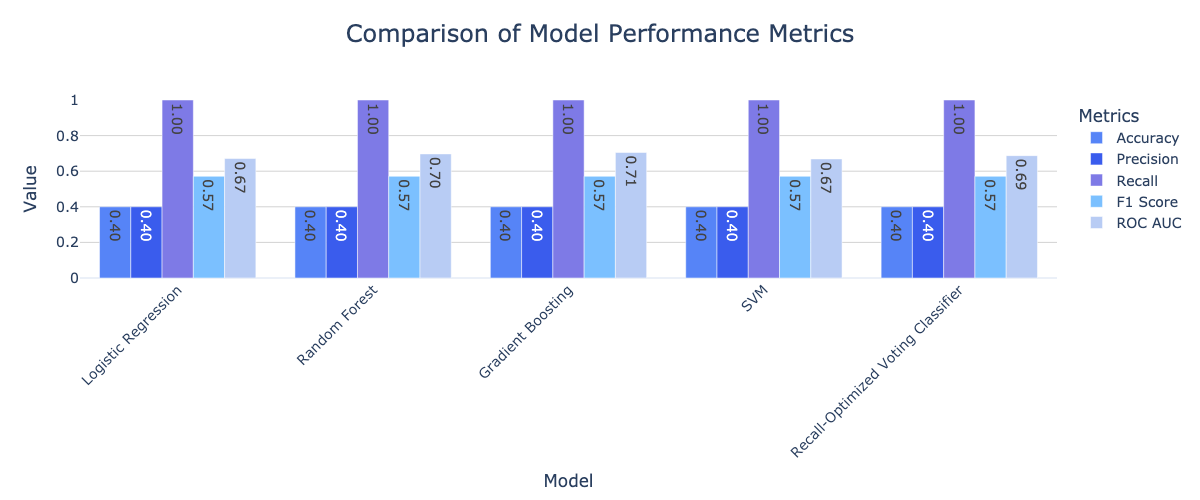

In [78]:
Image(filename="images/recall_focused_models_performance.png")

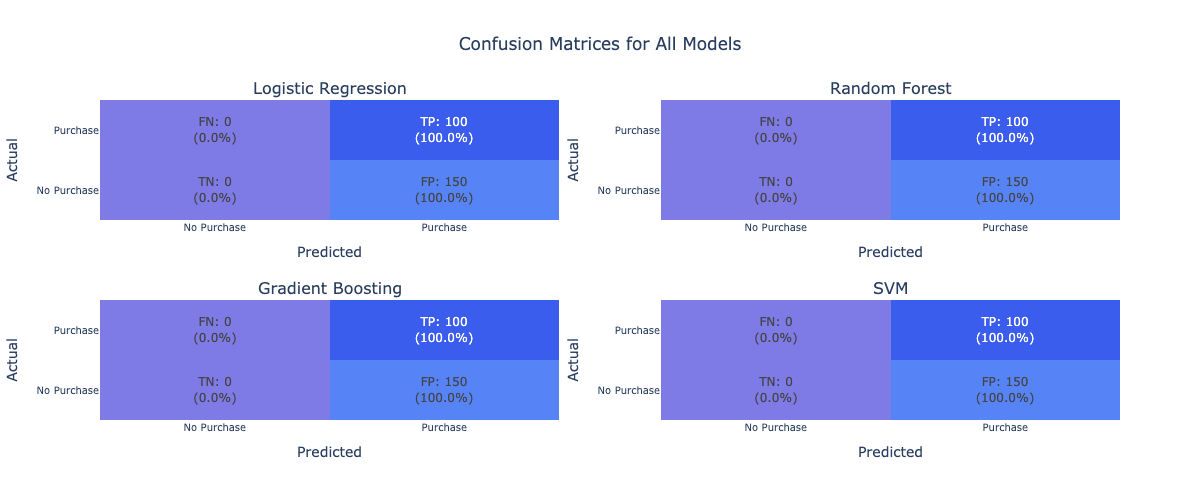

In [80]:
Image(filename="images/recall_focused_confusion_matrices.png")

**Recall focused Model Performance Comparison**

Based on the performance metrics shown in the plot, all models achieve perfect recall (100%), capturing every potential customer. However, there are differences in their ROC AUC scores and optimized thresholds:

| Model                              | ROC AUC | Threshold |
| ---------------------------------- | ------- | --------- |
| Logistic Regression                | 0.6712  | 0.2224    |
| Random Forest                      | 0.7012  | 0.0188    |
| Gradient Boosting                  | 0.7052  | 0.0000    |
| SVM                                | 0.6689  | 0.1567    |
| Recall-Optimized Voting Classifier | 0.6874  | 0.1273    |

**Key Findings**

- All models have the same recall (100%), precision (40%), F1 score (0.5714), and accuracy (40%).
- The Random Forest model has the highest ROC AUC score of 0.7012, indicating slightly better overall discriminatory power.
- The Recall-Optimized Voting Classifier combines the strengths of individual models and achieves an ROC AUC of 0.6874.
- Thresholds vary among models, with lower thresholds favoring higher recall at the cost of more false positives.

**Recommendation**

Considering the different approaches and their results, the **Random Forest model** emerges as the best overall choice for the following reasons:

1. **Balanced Performance**: In the hyperparameter tuning approach, it achieved the highest overall performance across multiple metrics.
2. **Best Discriminatory Power**: In the recall-optimized approach, it maintained the highest ROC AUC score (0.7012) while achieving perfect recall.
3. **Flexibility**: It performs well in both balanced and recall-optimized scenarios, indicating adaptability to different business needs.

However, the final choice depends on the specific business priorities:

- If the goal is to balance precision and recall, use the hyperparameter-tuned Random Forest model.
- If the priority is to capture all potential customers at the cost of more false positives, use the recall-optimized Random Forest model.

For a middle-ground approach, consider using the Recall-Optimized Voting Classifier, which combines the strengths of multiple models and achieves a good ROC AUC (0.6831) while maintaining perfect recall.


In [97]:
feature_names = X_test.columns.tolist()

model_feature_importances = {}

for name, model in best_models.items():
    model_feature_importances[name] = extract_feature_importances(model, X_test, y_test)

model_feature_importances['Recall-Optimized Voting Classifier'] = extract_feature_importances(voting_clf, X_test, y_test)

feature_importance_df = pd.DataFrame(model_feature_importances, index=feature_names)

transposed_df = feature_importance_df.T 
print(transposed_df)


                                         Age  GraduateOrNot  FamilyMembers  \
Logistic Regression                -0.006933       0.001733       0.015200   
Random Forest                       0.188844       0.025965       0.175797   
Gradient Boosting                   0.233947       0.026746       0.202041   
SVM                                 0.032800       0.003200       0.021733   
Recall-Optimized Voting Classifier  0.057733       0.008933       0.048800   

                                    ChronicDiseases  FrequentFlyer  \
Logistic Regression                        0.000000       0.000000   
Random Forest                              0.032696       0.036930   
Gradient Boosting                          0.048395       0.037931   
SVM                                        0.001467       0.001200   
Recall-Optimized Voting Classifier         0.006533      -0.002667   

                                    EverTravelledAbroad  AnnualIncomeEuro  \
Logistic Regression              

**Feature Importance Analysis**

1. **AnnualIncomeEuro**: This feature consistently demonstrates the highest importance across all models, particularly in tree-based models such as Random Forest (0.415253) and Gradient Boosting (0.378516). This suggests that the annual income in euros is a strong predictor of the target variable.

2. **Demographic Features**: Features such as Age, GraduateOrNot, FamilyMembers, ChronicDiseases, FrequentFlyer, and EverTravelledAbroad exhibit relatively lower importances compared to AnnualIncomeEuro. While these features may still contribute to the model's predictions, their impact appears to be less significant.

3. **Employment-related Features**: The features Emp_Government Sector and Emp_Private Sector/Self Employed also show lower importances across the models. This implies that the employment sector may not be a strong indicator of the target variable in this particular dataset.

4. **Model Comparison**: SVM and Logistic Regression generally assign lower importances to features compared to tree-based models like Random Forest and Gradient Boosting. This difference in feature importance assignment could be attributed to the inherent differences in how these models handle and interpret feature relationships.

5. **Recall-Optimized Voting Classifier**: The Recall-Optimized Voting Classifier exhibits mixed results, with some features having negative importances. This is likely due to the ensemble nature of the model, where multiple models' predictions are combined. The negative importances suggest that some features may have a contradictory effect on the ensemble's predictions.

### Conclusions:

1. The Random Forest model achieved the best overall performance in predicting travel insurance purchases after hyperparameter tuning. It maintained the highest ROC AUC score (0.7012) while achieving perfect recall in the recall-optimized approach.

2. Key factors influencing travel insurance purchase include:

   - Employment type (government sector, private sector/self-employed)
   - Frequent flyer status
   - International travel experience
   - Annual income

3. Demographics like age and family size showed some differences between insurance purchasers and non-purchasers but were less impactful than the above factors. Education level and chronic disease status did not significantly influence the purchase decision.

4. When optimizing models to maximize recall (capturing all potential customers), all models achieved 100% recall but with increased false positives. The Random Forest model maintained the best discriminatory power (ROC AUC) in this high-recall scenario.

Recommendations:

1. Implement the tuned Random Forest model for predicting potential travel insurance customers. It delivers the best balance of precision and recall.

2. If the business priority is capturing every potential customer, even at the cost of more false positives, use the recall-optimized Random Forest model instead. It achieved 100% recall with the highest ROC AUC.

3. Focus marketing efforts on the key influential customer segments:

   - Government and private sector/self-employed individuals
   - Frequent flyers
   - Those with prior international travel experience
   - Higher income individuals

4. Consider pricing and product strategies tailored to less predictive but still relevant segments like different age groups and family sizes.

5. Continuously gather more customer data and retrain the model periodically to adapt to evolving customer behaviors and market trends. Explore collecting additional relevant features.

6. Conduct a cost-benefit analysis to determine the optimal trade-off between customer acquisition (recall) and false positives (precision) for the travel insurance business. Use this to fine-tune the model's classification threshold.

By implementing these recommendations, the travel insurance company can effectively target high-potential customers, tailor its offerings, and optimize its marketing ROI. The chosen predictive model should be integrated into the customer acquisition workflow and continuously monitored and updated for maximum business impact.


In [88]:
%run -i travel_insurance_utils.py